### This script tests individual functions of the diarization function

#### Import packages

In [122]:
from __future__ import print_function
import numpy as np
import sklearn.cluster
import scipy
import os
from pyAudioAnalysis import ShortTermFeatures as sF
from pyAudioAnalysis import MidTermFeatures as aF
from pyAudioAnalysis import audioTrainTest as aT
from pyAudioAnalysis import audioBasicIO
from scipy.spatial import distance
from pyAudioAnalysis import audioSegmentation as aS
import matplotlib.pyplot as plt
import sklearn.discriminant_analysis
import csv
import os.path
import sklearn
import sklearn.cluster
import hmmlearn.hmm
import pickle as cPickle
import glob

#### Import diarization functions

In [123]:
""" General utility functions """

from pyAudioAnalysis.audioSegmentation import (smoothMovingAvg,
                                               selfSimilarityMatrix,
                                               flags2segs,
                                               segs2flags,
                                               computePreRec,
                                               readSegmentGT,
                                               plotSegmentationResults,
                                               evaluateSpeakerDiarization,
                                               trainHMM_computeStatistics,
                                               trainHMM_fromFile,
                                               trainHMM_fromDir,
                                               hmmSegmentation,
                                               mtFileClassification,
                                               evaluateSegmentationClassificationDir,
                                               silenceRemoval,
                                               speakerDiarizationEvaluateScript,
                                               musicThumbnailing
                                              )

#### Set parameters

In [124]:
# filename="./pyAudioAnalysis/data/Greenway/Conversation.wav"
# filename="./pyAudioAnalysis/data/Greenway/PhysicianPatientConversation.wav"
filename="./pyAudioAnalysis/data/Greenway/test_1_min.wav"
n_speakers=2
mt_size=2.0
mt_step=0.2
st_win=0.05
lda_dim=35
plot_res=1

#### pathname

In [125]:
pathname='C:\\Users\\anfrankl\\Desktop\\pyAudioAnalysis\\pyAudioAnalysis'

#### Read the audio file

In [126]:
[fs, x] = audioBasicIO.read_audio_file(filename)
x = audioBasicIO.stereo_to_mono(x)
duration = len(x) / fs


In [127]:
duration

59.989333333333335

#### Segment audio

In [128]:
[classifier_1, MEAN1, STD1, classNames1, mtWin1, mtStep1, stWin1, stStep1, computeBEAT1] = aT.load_model_knn(os.path.join(pathname, "data\\models", "knn_speaker_10"))
[classifier_2, MEAN2, STD2, classNames2, mtWin2, mtStep2, stWin2, stStep2, computeBEAT2] = aT.load_model_knn(os.path.join(pathname, "data\\models", "knn_speaker_male_female"))

#### Midterm features

In [129]:
[mt_feats, st_feats, _] = aF.mid_feature_extraction(x, fs, mt_size * fs,
                                                    mt_step * fs,
                                                    round(fs * st_win),
                                                    round(fs*st_win * 0.5))

MidTermFeatures2 = np.zeros((mt_feats.shape[0] + len(classNames1) +
                                len(classNames2), mt_feats.shape[1]))

#### Normalize features

In [130]:
for i in range(mt_feats.shape[1]):
    cur_f1 = (mt_feats[:, i] - MEAN1) / STD1
    cur_f2 = (mt_feats[:, i] - MEAN2) / STD2
    [res, P1] = aT.classifierWrapper(classifier_1, "knn", cur_f1)
    [res, P2] = aT.classifierWrapper(classifier_2, "knn", cur_f2)
    MidTermFeatures2[0:mt_feats.shape[0], i] = mt_feats[:, i]
    MidTermFeatures2[mt_feats.shape[0]:mt_feats.shape[0]+len(classNames1), i] = P1 + 0.0001
    MidTermFeatures2[mt_feats.shape[0] + len(classNames1)::, i] = P2 + 0.0001

mt_feats = MidTermFeatures2    # TODO
iFeaturesSelect = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 41,
                   42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]

mt_feats = mt_feats[iFeaturesSelect, :]

(mt_feats_norm, MEAN, STD) = aT.normalizeFeatures([mt_feats.T])
mt_feats_norm = mt_feats_norm[0].T
n_wins = mt_feats.shape[1]

#### Remove Outliers

In [131]:
# remove outliers:
dist_all = np.sum(distance.squareform(distance.pdist(mt_feats_norm.T)),
                     axis=0)
m_dist_all = np.mean(dist_all)
i_non_outliers = np.nonzero(dist_all < 1.2 * m_dist_all)[0]

In [132]:
perOutLier = (100.0 * (n_wins - i_non_outliers.shape[0])) / n_wins
mt_feats_norm_or = mt_feats_norm
mt_feats_norm = mt_feats_norm[:, i_non_outliers]

#### LDA Dimensionality Reduction

In [133]:
# LDA dimensionality reduction:
if lda_dim > 0:
    #[mt_feats_to_red, _, _] = aF.mtFeatureExtraction(x, fs, mt_size * fs,
    # st_win * fs, round(fs*st_win), round(fs*st_win));
    # extract mid-term features with minimum step:
    mt_win_ratio = int(round(mt_size / st_win))
    mt_step_ratio = int(round(st_win / st_win))
    mt_feats_to_red = []
    num_of_features = len(st_feats)
    num_of_stats = 2
    #for i in range(num_of_stats * num_of_features + 1):
    for i in range(num_of_stats * num_of_features):
        mt_feats_to_red.append([])

    for i in range(num_of_features):  # for each of the short-term features:
        curPos = 0
        N = len(st_feats[i])
        while (curPos < N):
            N1 = curPos
            N2 = curPos + mt_win_ratio
            if N2 > N:
                N2 = N
            curStFeatures = st_feats[i][N1:N2]
            mt_feats_to_red[i].append(np.mean(curStFeatures))
            mt_feats_to_red[i+num_of_features].append(np.std(curStFeatures))
            curPos += mt_step_ratio
    mt_feats_to_red = np.array(mt_feats_to_red)
    mt_feats_to_red_2 = np.zeros((mt_feats_to_red.shape[0] +
                                    len(classNames1) + len(classNames2),
                                     mt_feats_to_red.shape[1]))
    for i in range(mt_feats_to_red.shape[1]):
        cur_f1 = (mt_feats_to_red[:, i] - MEAN1) / STD1
        cur_f2 = (mt_feats_to_red[:, i] - MEAN2) / STD2
        [res, P1] = aT.classifierWrapper(classifier_1, "knn", cur_f1)
        [res, P2] = aT.classifierWrapper(classifier_2, "knn", cur_f2)
        mt_feats_to_red_2[0:mt_feats_to_red.shape[0], i] = mt_feats_to_red[:, i]
        mt_feats_to_red_2[mt_feats_to_red.shape[0]:mt_feats_to_red.shape[0] + len(classNames1), i] = P1 + 0.0001
        mt_feats_to_red_2[mt_feats_to_red.shape[0]+len(classNames1)::, i] = P2 + 0.0001
    mt_feats_to_red = mt_feats_to_red_2
    mt_feats_to_red = mt_feats_to_red[iFeaturesSelect, :]
    #mt_feats_to_red += np.random.rand(mt_feats_to_red.shape[0], mt_feats_to_red.shape[1]) * 0.0000010
    (mt_feats_to_red, MEAN, STD) = aT.normalizeFeatures([mt_feats_to_red.T])
    mt_feats_to_red = mt_feats_to_red[0].T
    #dist_all = np.sum(distance.squareform(distance.pdist(mt_feats_to_red.T)), axis=0)
    #m_dist_all = np.mean(dist_all)
    #iNonOutLiers2 = np.nonzero(dist_all < 3.0*m_dist_all)[0]
    #mt_feats_to_red = mt_feats_to_red[:, iNonOutLiers2]
    Labels = np.zeros((mt_feats_to_red.shape[1], ));
    LDAstep = 1.0
    LDAstepRatio = LDAstep / st_win
    #print LDAstep, LDAstepRatio
    for i in range(Labels.shape[0]):
        Labels[i] = int(i*st_win/LDAstepRatio);        
    clf = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=lda_dim)
    clf.fit(mt_feats_to_red.T, Labels)
    mt_feats_norm = (clf.transform(mt_feats_norm.T)).T

C:\Users\anfrankl\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(26, 6 - 1) = 5 components.
  ChangedBehaviorWarning)
C:\Users\anfrankl\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [134]:
if n_speakers <= 0:
    s_range = range(2, 10)
else:
    s_range = [n_speakers]
clsAll = []
sil_all = []
centersAll = []

In [135]:
for iSpeakers in s_range:        
    k_means = sklearn.cluster.KMeans(n_clusters=iSpeakers)
    k_means.fit(mt_feats_norm.T)
    cls = k_means.labels_        
    means = k_means.cluster_centers_

    # Y = distance.squareform(distance.pdist(mt_feats_norm.T))
    clsAll.append(cls)
    centersAll.append(means)
    sil_1 = []; sil_2 = []
    for c in range(iSpeakers):
        # for each speaker (i.e. for each extracted cluster)
        clust_per_cent = np.nonzero(cls == c)[0].shape[0] / \
                         float(len(cls))
        if clust_per_cent < 0.020:
            sil_1.append(0.0)
            sil_2.append(0.0)
        else:
            # get subset of feature vectors
            mt_feats_norm_temp = mt_feats_norm[:, cls==c]
            # compute average distance between samples
            # that belong to the cluster (a values)
            Yt = distance.pdist(mt_feats_norm_temp.T)
            sil_1.append(np.mean(Yt)*clust_per_cent)
            silBs = []
            for c2 in range(iSpeakers):
                # compute distances from samples of other clusters
                if c2 != c:
                    clust_per_cent_2 = np.nonzero(cls == c2)[0].shape[0] /\
                                       float(len(cls))
                    MidTermFeaturesNormTemp2 = mt_feats_norm[:, cls == c2]
                    Yt = distance.cdist(mt_feats_norm_temp.T, 
                                        MidTermFeaturesNormTemp2.T)
                    silBs.append(np.mean(Yt)*(clust_per_cent
                                                 + clust_per_cent_2)/2.0)
            silBs = np.array(silBs)
            # ... and keep the minimum value (i.e.
            # the distance from the "nearest" cluster)
            sil_2.append(min(silBs))
    sil_1 = np.array(sil_1); 
    sil_2 = np.array(sil_2); 
    sil = []
    for c in range(iSpeakers):
        # for each cluster (speaker) compute silhouette
        sil.append( ( sil_2[c] - sil_1[c]) / (max(sil_2[c],
                                                  sil_1[c]) + 0.00001))
    # keep the AVERAGE SILLOUETTE
    sil_all.append(np.mean(sil))


#### Number of speakers

In [136]:
imax = np.argmax(sil_all)
# optimal number of clusters
nSpeakersFinal = s_range[imax]


In [137]:
nSpeakersFinal

2

#### Final cluster labels

In [138]:
# generate the final set of cluster labels
# (important: need to retrieve the outlier windows:
# this is achieved by giving them the value of their
# nearest non-outlier window)
cls = np.zeros((n_wins,))
for i in range(n_wins):
    j = np.argmin(np.abs(i-i_non_outliers))        
    cls[i] = clsAll[imax][j]


#### Postprocess for smoothing

In [139]:
# Post-process method 1: hmm smoothing
for i in range(1):
    # hmm training
    start_prob, transmat, means, cov = \
        trainHMM_computeStatistics(mt_feats_norm_or, cls)
    hmm = hmmlearn.hmm.GaussianHMM(start_prob.shape[0], "diag")
    hmm.startprob_ = start_prob
    hmm.transmat_ = transmat            
    hmm.means_ = means; hmm.covars_ = cov
    cls = hmm.predict(mt_feats_norm_or.T)                    

# Post-process method 2: median filtering:
cls = scipy.signal.medfilt(cls, 13)
cls = scipy.signal.medfilt(cls, 11)

sil = sil_all[imax]
class_names = ["speaker{0:d}".format(c) for c in range(nSpeakersFinal)];


#### Load Ground Truth if available

In [140]:
# load ground-truth if available
gt_file = filename.replace('.wav', '.segments')
# if groundturh exists
if os.path.isfile(gt_file):
    [seg_start, seg_end, seg_labs] = readSegmentGT(gt_file)
    flags_gt, class_names_gt = segs2flags(seg_start, seg_end, seg_labs, mt_step)

In [141]:
filename

'./pyAudioAnalysis/data/Greenway/test_1_min.wav'

In [142]:
os.path.isfile(gt_file)

False

In [143]:
gt_file

'./pyAudioAnalysis/data/Greenway/test_1_min.segments'

#### Develop Plots

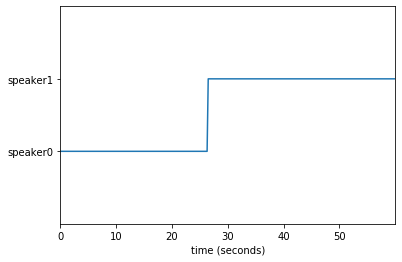

In [144]:
if plot_res:
    fig = plt.figure()    
    if n_speakers > 0:
        ax1 = fig.add_subplot(111)
    else:
        ax1 = fig.add_subplot(211)
    ax1.set_yticks(np.array(range(len(class_names))))
    ax1.axis((0, duration, -1, len(class_names)))
    ax1.set_yticklabels(class_names)
    ax1.plot(np.array(range(len(cls)))*mt_step+mt_step/2.0, cls)

if os.path.isfile(gt_file):
    if plot_res:
        ax1.plot(np.array(range(len(flags_gt))) *
                 mt_step + mt_step / 2.0, flags_gt, 'r')
    purity_cluster_m, purity_speaker_m = \
        evaluateSpeakerDiarization(cls, flags_gt)
    print("{0:.1f}\t{1:.1f}".format(100 * purity_cluster_m,
                                    100 * purity_speaker_m))
    if plot_res:
        plt.title("Cluster purity: {0:.1f}% - "
                  "Speaker purity: {1:.1f}%".format(100 * purity_cluster_m,
                                                    100 * purity_speaker_m))
if plot_res:
    plt.xlabel("time (seconds)")
    #print s_range, sil_all    
    if n_speakers<=0:
        plt.subplot(212)
        plt.plot(s_range, sil_all)
        plt.xlabel("number of clusters");
        plt.ylabel("average clustering's sillouette");
    plt.show()


In [145]:
class_names

['speaker0', 'speaker1']

In [146]:
mt_step

0.2

In [159]:
time_vec=np.array(range(len(cls)))*mt_step+mt_step/2.0

In [148]:
cls

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

#### Find Change points

In [149]:
speaker_change_index=np.where(np.roll(cls,1)!=cls)[0]

In [150]:
speaker_change_index

array([  0, 132], dtype=int64)

In [158]:
len(speaker_change_index)

2

In [153]:
len(cls)

300

In [156]:
temp[132]

26.500000000000004

In [155]:
print(cls[135], cls[136])

1.0 1.0


In [166]:
from datetime import datetime
import pprint

In [168]:
output_list=[]
temp={}
for ind,sc in enumerate(speaker_change_index):
    temp['dialogue_id']= str(datetime.now()).strip()
    temp['speaker']=list(cls)[sc]
    temp['start_time']=time_vec[sc]
    temp['end_time']=time_vec[speaker_change_index[ind+1]-1] if ind+1<len(speaker_change_index) else time_vec[-1]
    temp["text"]=None
    output_list.append(temp)
    temp={}
    
pprint.pprint(output_list)


[{'dialogue_id': '2020-02-13 15:04:18.148188',
  'end_time': 26.300000000000004,
  'speaker': 0.0,
  'start_time': 0.1,
  'text': None},
 {'dialogue_id': '2020-02-13 15:04:18.148188',
  'end_time': 59.900000000000006,
  'speaker': 1.0,
  'start_time': 26.500000000000004,
  'text': None}]


#### Wav snippets

In [170]:
def save_snippet(output_list,filename,output_folder):
    for ind,diag in enumerate(output_list):
        t1=diag['start_time']
        t2=diag['end_time']
        newAudio = AudioSegment.from_wav(filename)
        newAudio = newAudio[diag['start_time']:diag['end_time']]
        filename_out=output_folder+ f"snippet_{str(t1)[:4]}_{str(t2)[:4]}.wav"
        newAudio.export(filename_out, format="wav") #Exports to a wav file in the current path.

In [171]:
save_snippet(output_list,filename,"./pyAudioAnalysis/data/Greenway/")

### transcribe the wav snippets